In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/autoencoder-nssc/sampled_data.npz
/kaggle/input/autoencoder-nssc/test_data.npz


**For this we took 35 records and applied undersampling, because we were having storage issues, the undersampled data is stored in "sampled_data.npz"**

In [3]:
data = np.load("/kaggle/input/autoencoder-nssc/sampled_data.npz")
X = data['x']
y = data['y']

In [4]:
X = np.repeat(X[..., np.newaxis], 3, axis=-1)
X = X.astype('float32') / 255.0

***quark (q) and gluon (g) jets are considered Standard Model (SM) background processes — i.e., they are well-understood and common in proton-proton collisions.***

In [ ]:
normal_classes = [0, 1]  # j_g and j_q
anomalous_classes = [2, 3, 4]

# splitting into normal and anomalous jets
X_normal = X[np.isin(y, normal_classes)]
X_anom = X[np.isin(y, anomalous_classes)]

In [6]:
# split normal jets into train/validation
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)

In [7]:
print("Normal jets for training:", X_train.shape)
print("Validation normal jets:", X_val.shape)
print("Anomalous jets:", X_anom.shape)

Normal jets for training: (9494, 100, 100, 3)
Validation normal jets: (2374, 100, 100, 3)
Anomalous jets: (18132, 100, 100, 3)


In [8]:
input_shape = X_train.shape[1:]
latent_dim = 256  
# captures key jet structure while allowing differences (t/W/Z) to appear as higher reconstruction loss.
# we took moderate latent dimension because of the above reason

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Cropping2D, Dropout,UpSampling2D, Conv2D, MaxPooling2D,Flatten,Reshape,Conv2DTranspose
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU

# Architecture of the autoencoder

In [10]:
alpha_value = 0.2
inp = Input(shape=input_shape)
# Encoder
x = Conv2D(32, (3,3), activation='relu', padding='same')(inp)
x = LeakyReLU(alpha=alpha_value)(x)
x = MaxPooling2D((2,2), padding='same')(x)   # 50x50
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = LeakyReLU(alpha=alpha_value)(x)
x = MaxPooling2D((2,2), padding='same')(x)   # 25x25
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = LeakyReLU(alpha=alpha_value)(x)
x = MaxPooling2D((2,2), padding='same')(x)   # 13x13
x = Flatten()(x)
encoded = Dense(latent_dim, activation='relu', name="bottleneck")(x)
encoded = LeakyReLU(alpha=alpha_value)(encoded)

#Decoder
x = Dense(13*13*128, activation='relu')(encoded)
x = LeakyReLU(alpha=alpha_value)(x)
x = Reshape((13,13,128))(x)
x = Conv2DTranspose(128, (3,3), activation='relu', padding='same')(x)
x = LeakyReLU(alpha=alpha_value)(x)
x = UpSampling2D((2,2))(x)   # 26x26
x = Conv2DTranspose(64, (3,3), activation='relu', padding='same')(x)
x = LeakyReLU(alpha=alpha_value)(x)
x = UpSampling2D((2,2))(x)   # 52x52
x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)   # 104x104
decoded = Conv2DTranspose(input_shape[-1], (3,3), activation='linear', padding='same')(x)
decoded = Cropping2D(((2,2),(2,2)))(decoded)

autoencoder = Model(inp, decoded)
autoencoder.compile(optimizer=Adam(1e-3), loss='mse')
autoencoder.summary()

I0000 00:00:1760555032.006900    2788 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760555032.007579    2788 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 256)            │     5,538,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 21632)          │     5,559,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 13, 13, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 26, 26, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 52, 52, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 52, 52, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 11,431,427 (43.61 MB)

 Trainable params: 11,431,427 (43.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, X_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


I0000 00:00:1760555043.341772    2827 service.cc:148] XLA service 0x7d9a08010e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760555043.342490    2827 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760555043.342545    2827 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760555043.846462    2827 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/149 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 5.3525e-04

I0000 00:00:1760555049.833117    2827 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


149/149 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - loss: 4.4117e-04 - val_loss: 3.2950e-04
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 3.0226e-04 - val_loss: 2.0758e-04
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 1.9957e-04 - val_loss: 1.6765e-04
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 1.6330e-04 - val_loss: 1.5312e-04
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 1.4908e-04 - val_loss: 1.3356e-04
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 1.3290e-04 - val_loss: 1.2093e-04
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 1.2052e-04 - val_loss: 1.1306e-04
Epoch 8/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 1.1184e-04 - val_loss: 1.0654e-04
Epoch 9/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 1.0429e-04 - val_loss: 1.0524e-04
Epoch 10/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 1.0235e-04 - val_loss: 9.9168e-05
Epoch 11/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - los

In [12]:
# reconstruction error
def reconstruction_error(model, data):
    recon = model.predict(data, verbose=0)
    return np.mean(np.square(data - recon), axis=(1,2,3))

mse_normal = reconstruction_error(autoencoder, X_val)
mse_anom = reconstruction_error(autoencoder, X_anom)

# Plotting the distribution of errors

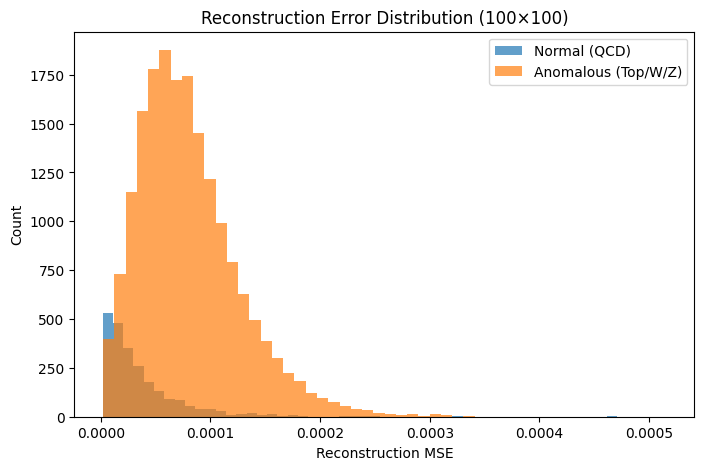

In [13]:
plt.figure(figsize=(8,5))
plt.hist(mse_normal, bins=50, alpha=0.7, label="Normal (QCD)")
plt.hist(mse_anom, bins=50, alpha=0.7, label="Anomalous (Top/W/Z)")
plt.xlabel("Reconstruction MSE")
plt.ylabel("Count")
plt.legend()
plt.title("Reconstruction Error Distribution (100×100)")
plt.show()

In [14]:
from sklearn.metrics import roc_auc_score
# threshold and evaluation
threshold = np.mean(mse_normal) + 2*np.std(mse_normal)
print("Chosen threshold:", threshold)

y_true = np.concatenate([np.zeros(len(mse_normal)), np.ones(len(mse_anom))])
y_score = np.concatenate([mse_normal, mse_anom])
y_pred = y_score > threshold

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomalous"]))
print("ROC-AUC:", roc_auc_score(y_true, y_score))

Chosen threshold: 0.00012025871546939015
[[ 2273   101]
 [15040  3092]]
              precision    recall  f1-score   support

      Normal       0.13      0.96      0.23      2374
   Anomalous       0.97      0.17      0.29     18132

    accuracy                           0.26     20506
   macro avg       0.55      0.56      0.26     20506
weighted avg       0.87      0.26      0.28     20506

ROC-AUC: 0.8127514323956992


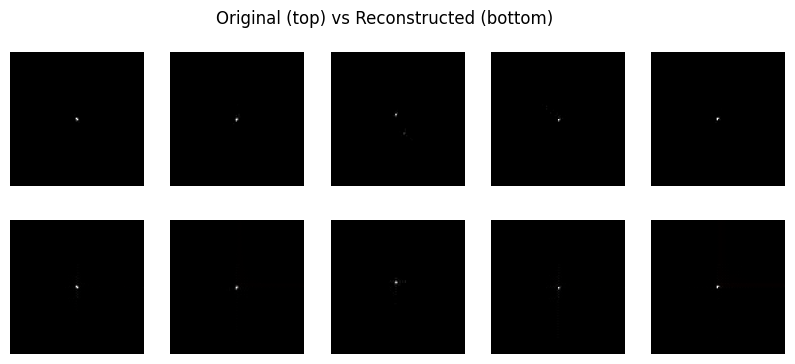

In [15]:
# visualize reconstruction
def plot_reconstructions(model, data, n=5):
    idx = np.random.choice(len(data), n)
    recon = model.predict(data[idx], verbose=0)
    plt.figure(figsize=(10,4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(data[idx[i]].squeeze(), cmap="inferno")
        plt.axis("off")
        plt.subplot(2, n, n+i+1)
        plt.imshow(recon[i].squeeze(), cmap="inferno")
        plt.axis("off")
    plt.suptitle("Original (top) vs Reconstructed (bottom)")
    plt.show()

plot_reconstructions(autoencoder, X_val)

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
--- 1. Top 5 Anomaly Visualization ---


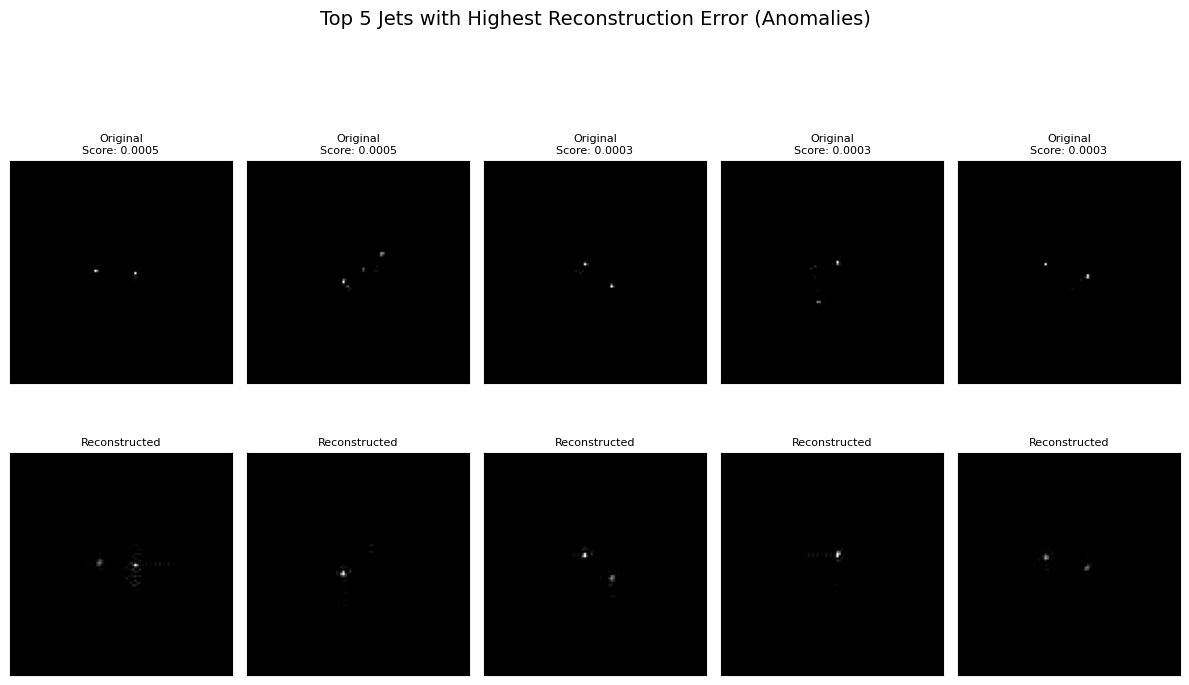


--- 2. Anomaly Detection Count ---
Chosen Anomaly Threshold (MSE): 0.0002
Total Test Samples: 2374
Total number of anomalies detected: 12 (Jets with MSE >= 0.0002)


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

X_test_pred = autoencoder.predict(X_val)

# Mean Squared Error (MSE) for each jet
mse_scores = np.mean(np.power(X_val - X_test_pred, 2), axis=(1, 2, 3))


# Visualizing the top 5 jets with the highest reconstruction errors


print("--- 1. Top 5 Anomaly Visualization ---")


top_5_indices = np.argsort(mse_scores)[-5:][::-1]

# --- Plotting ---
n = 5
plt.figure(figsize=(12, 4 * 2))

for i in range(n):
    
    idx = top_5_indices[i]
    original_jet = X_val[idx]
    reconstructed_jet = X_test_pred[idx]
    score = mse_scores[idx]

    # Plotting Original Jet (Top Row)
    ax = plt.subplot(2, n, i + 1)
    
    plt.imshow(original_jet.squeeze(), cmap='gray')
    ax.set_title(f"Original\nScore: {score:.4f}", fontsize=8)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Plot Reconstructed Jet (Bottom Row)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_jet.squeeze(), cmap='gray')
    ax.set_title(f"Reconstructed", fontsize=8)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.suptitle("Top 5 Jets with Highest Reconstruction Error (Anomalies)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.show()


# Printing the total number of anomalies detected


# --- Determine the Anomaly Threshold ---
# We used the 99.5th percentile of the full test set MSE as a simple threshold.

threshold = np.percentile(mse_scores, 99.5) 

detected_anomalies_indices = np.where(mse_scores >= threshold)[0]
total_detected_anomalies = len(detected_anomalies_indices)

print("\n--- 2. Anomaly Detection Count ---")
print(f"Chosen Anomaly Threshold (MSE): {threshold:.4f}")
print(f"Total Test Samples: {len(X_val)}")
print(f"Total number of anomalies detected: {total_detected_anomalies} (Jets with MSE >= {threshold:.4f})")

